In [140]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from google.cloud import bigquery
from google.cloud import storage

import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.use_bqstorage_api = True

### Get label distribution of BigQuery table

In [141]:
%%bigquery df
SELECT Class as fraud, count(*) num_examples FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
GROUP BY 1

In [142]:
df.head()

,fraud,num_examples
0,0,284315
1,1,492


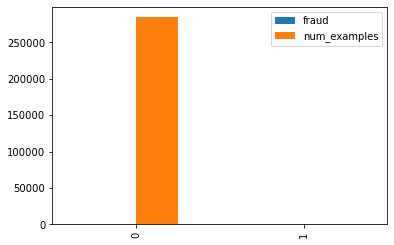

In [143]:
df.plot(kind='bar')

## Save fraud transactions to Pandas DataFrame

In [144]:
%%bigquery fraud
SELECT * FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 1

### Use downsampling to get a random sample of fraudulent transactions from BQ data

We're using the BigQuery Storage API, which speeds up our data download using distributed processing.

In [146]:
%%bigquery non_fraud --use_bqstorage_api
SELECT * FROM (
    SELECT 
        *,  
        MOD(CAST(RAND()*100 AS INT64),100)=0 as rownum
    FROM `bigquery-public-data.ml_datasets.ulb_fraud_detection`
    WHERE Class = 0
)
WHERE rownum = True

In [147]:
updated_data = pd.concat([fraud, non_fraud])
updated_data = updated_data.drop(columns=['rownum'])

In [148]:
updated_data.head()

,Time,Amount,Class,temp_during_purchase,swipe_acceleration,cc_weight,cc_color,cc_material,cc_temp,num_backwards_swipes,...,sparks_joy_confidence,want_v_need_rating,rainfall_at_purchase,is_cake_confidence,cash_back_points,time_waiting_for_chip,treat_yourself,signature_color,signature_smudges,time_to_cc_expiry
0,406.0,0.0,1,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,...,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276
1,12093.0,0.0,1,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,...,0.991486,-0.158971,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075
2,32686.0,0.0,1,0.287953,1.728735,-1.652173,3.813544,-1.090927,-0.984745,-2.202318,...,-0.902690,0.265250,0.262202,-0.633528,0.092891,0.187613,0.368708,-0.132474,0.576561,0.309843
3,41233.0,0.0,1,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,...,3.118480,-0.046170,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908
4,53658.0,0.0,1,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,...,-0.603726,0.002749,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952


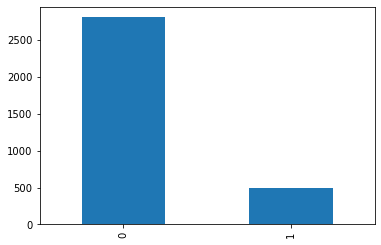

In [149]:
# Plot the updated data distribution
updated_data['Class'].value_counts().plot(kind='bar')

### Write the updated data to a new BigQuery table

Below, replace `dataset_name`, `table_name`, and `project_name` with the name of your Google Cloud dataset, table, and project respectively.

In [150]:
updated_data.to_gbq(
    "dataset_name.table_name", 
    "project_name", 
    if_exists='replace'
)

1it [00:03,  3.98s/it]
